# Lab 01 : LeNet5 ChebGCNs - AXEL


Spectral Graph ConvNets<br>
Convolutional Neural Networks on Graphs with Fast Localized Spectral Filtering<br>
M Defferrard, X Bresson, P Vandergheynst<br>
Advances in Neural Information Processing Systems, 3844-3852, 2016<br>
ArXiv preprint: [arXiv:1606.09375](https://arxiv.org/pdf/1606.09375.pdf) <br>

DOC : https://docs.dgl.ai/en/latest/api/python/nn.pytorch.html?highlight=cheb#dgl.nn.pytorch.conv.ChebConv

In [1]:
import os
import sys
import time
import random
import numpy as np

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import dgl
import networkx as nx
import matplotlib.pyplot as plt

#import collections
# MAC PROBLEM THAT MAKES THE NOTEBOOK Crash
os.environ['KMP_DUPLICATE_LIB_OK']='True'


sys.path.insert(0, 'lib/')
%load_ext autoreload
%autoreload 2

In [2]:
# GPU Compatibility
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

if torch.cuda.is_available():
    print('cuda available')
    dtypeFloat = torch.cuda.FloatTensor
    dtypeLong = torch.cuda.LongTensor
    torch.cuda.manual_seed(1)
else:
    print('cuda not available')
    dtypeFloat = torch.FloatTensor
    dtypeLong = torch.LongTensor
    torch.manual_seed(1)

cuda not available


# MNIST

In [3]:
def check_mnist_dataset_exists(path_data='./'):
    flag_train_data = os.path.isfile(path_data + 'mnist/train_data.pt')
    flag_train_label = os.path.isfile(path_data + 'mnist/train_label.pt')
    flag_test_data = os.path.isfile(path_data + 'mnist/test_data.pt')
    flag_test_label = os.path.isfile(path_data + 'mnist/test_label.pt')
    if flag_train_data == False or flag_train_label == False or flag_test_data == False or flag_test_label == False:
        print('MNIST dataset missing - downloading...')
        import torchvision
        import torchvision.transforms as transforms
        trainset = torchvision.datasets.MNIST(root=path_data + 'mnist/temp', train=True,
                                              download=True, transform=transforms.ToTensor())
        testset = torchvision.datasets.MNIST(root=path_data + 'mnist/temp', train=False,
                                             download=True, transform=transforms.ToTensor())
        train_data = torch.Tensor(60000, 28, 28)
        train_label = torch.LongTensor(60000)
        
        for idx, example in enumerate(trainset):
            train_data[idx] = example[0].squeeze()
            train_label[idx] = example[1]

        torch.save(train_data, path_data + 'mnist/train_data.pt')
        torch.save(train_label, path_data + 'mnist/train_label.pt')
        test_data = torch.Tensor(10000, 28, 28)
        test_label = torch.LongTensor(10000)

        for idx, example in enumerate(testset):
            test_data[idx] = example[0].squeeze()
            test_label[idx] = example[1]
            
        torch.save(test_data, path_data + 'mnist/test_data.pt')
        torch.save(test_label, path_data + 'mnist/test_label.pt')
    return path_data


_ = check_mnist_dataset_exists()

In [4]:
nb_selected_train_data = 500
nb_selected_test_data = 100

train_data = torch.load('mnist/train_data.pt').reshape(60000, 784)
train_data = train_data[:nb_selected_train_data, :]
print(train_data.shape, type(train_data))

train_labels = torch.load('mnist/train_label.pt')
train_labels = train_labels[:nb_selected_train_data]
print(train_labels.shape)

test_data = torch.load('mnist/test_data.pt').reshape(10000, 784).numpy()
test_data = test_data[:nb_selected_test_data, :]
print(test_data.shape)

test_labels = torch.load('mnist/test_label.pt').numpy()
test_labels = test_labels[:nb_selected_test_data]
print(test_labels.shape)

torch.Size([500, 784]) <class 'torch.Tensor'>
torch.Size([500])
(100, 784)
(100,)


In [11]:
# Import the dataset from file
from Dataset import MNISTDataset

In [12]:
trainset = MNISTDataset(train_data,train_labels)
testset = MNISTDataset(test_data,test_labels)

In [7]:
def showGraph(graph, label):
    # Since the actual graph is undirected, we convert it
    nx_G = graph.to_networkx().to_undirected()

    # Kamada-Kawaii layout
    pos = nx.kamada_kawai_layout(nx_G)
    nx.draw(nx_G, pos, with_labels=False,
            cmap=plt.cm.Blues, node_color=graph.ndata['h'])
    plt.title('Class: {:d}'.format(label))
    plt.show()

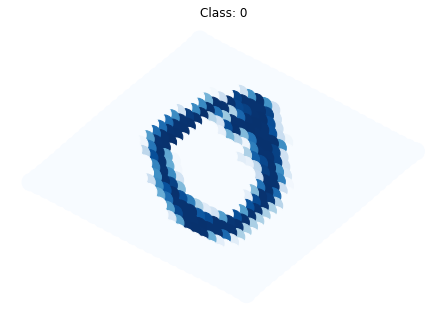

In [8]:
#showGraph(*trainset[1])

# Bis ChebNetDGL

In [9]:
def chebyshev(L, X, K):
    """Return T_k X where T_k are the Chebyshev polynomials of order up to K.
    Complexity is O(KMN)."""
    M, N = X.shape
    assert L.dtype == X.dtype

    # L = rescale_L(L, lmax)
    # Xt = T @ X: MxM @ MxN.
    # Xt_0 = T_0 X = I X = X.
    # Xt_1 = T_1 X = L X.
    # Xt_k = 2 L Xt_k-1 - Xt_k-2.
    
    Xt = np.empty((K, M, N), L.dtype)
    
    Xt[0, ...] = X
    if K > 1:
        Xt[1, ...] = L.dot(X)
        for k in range(2, K):
            Xt[k, ...] = 2 * L.dot(Xt[k-1, ...]) - Xt[k-2, ...]
    return Xt

In [10]:
## https://github.com/mdeff/cnn_graph/blob/c4d2c75d1807a1d1189b84bd6f4a0aafca5b8c53/lib/graph.py#L241

def rescale_L(L, lmax=2):
    """Rescale the Laplacian eigenvalues in [-1,1]."""
    M, M = L.shape
    I = scipy.sparse.identity(M, format='csr', dtype=L.dtype)
    L /= lmax / 2
    L -= I
    return L

# GCN

# Model

# Define a 2-layer GCN model
class GCN(nn.Module):
    def __init__(self, in_feats, num_classes):
        super(GCN, self).__init__()
        self.gcn1 = GCNLayer(in_feats, num_classes)

    def forward(self, g):
        h = self.gcn1(g)
        return h
    
net = GCN(1568, trainset.num_classes)

In [12]:
import dgl.function as fn
# Sends a message of node feature h.
msg = fn.copy_src(src='h', out='m')

def reduce(nodes):
    """Take an average over all neighbor node features hu and use it to
    overwrite the original node feature."""
    accum = torch.mean(nodes.mailbox['m'], 1)
    return {'h': accum}

class NodeApplyModule(nn.Module):
    """Update the node feature hv with ReLU(Whv+b)."""
    def __init__(self, in_feats, out_feats, activation):
        super(NodeApplyModule, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)
        self.activation = activation

    def forward(self, node):
        h = self.linear(node.data['h'])
        h = self.activation(h)
        return {'h' : h}

class GCN(nn.Module):
    def __init__(self, in_feats, out_feats, activation):
        super(GCN, self).__init__()
        self.apply_mod = NodeApplyModule(in_feats, out_feats, activation)

    def forward(self, g, feature):
        # Initialize the node features with h.
        g.ndata['h'] = feature
        g.update_all(msg, reduce)
        g.apply_nodes(func=self.apply_mod)
        return g.ndata.pop('h')

In [24]:
class Classifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes):
        super(Classifier, self).__init__()

        self.layers = nn.ModuleList([
            GCN(in_dim, hidden_dim, F.relu),
            GCN(hidden_dim, hidden_dim, F.relu)])
        self.classify = nn.Linear(hidden_dim, n_classes)

    def forward(self, g):
        # For undirected graphs, in_degree is the same as
        # out_degree.
        #h = g.in_degrees().view(-1, 1).float()
        for conv in self.layers:
            h = conv(g,g.ndata['h'])
        #g.ndata['h'] = h
        hg = dgl.mean_nodes(g, 'h')
        return self.classify(hg)

# Training

In [25]:
def collate(samples):
    # The input `samples` is a list of pairs
    #  (graph, label).
    graphs, labels = map(list, zip(*samples))
    batched_graph = dgl.batch(graphs)
    return batched_graph, torch.tensor(labels)

In [26]:
# Debug
dgl.batch((trainset[0][0],trainset[1][0]))

DGLGraph(num_nodes=1568, num_edges=6048,
         ndata_schemes={'h': Scheme(shape=(), dtype=torch.float32)}
         edata_schemes={})

In [27]:
# Use PyTorch's DataLoader and the collate function
# defined before.
data_loader = DataLoader(trainset, batch_size=2,
                         shuffle=True, collate_fn=collate)

# Create model
net = Classifier(1, 10, trainset.num_classes)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
net.train()

Classifier(
  (layers): ModuleList(
    (0): GCN(
      (apply_mod): NodeApplyModule(
        (linear): Linear(in_features=1, out_features=10, bias=True)
      )
    )
    (1): GCN(
      (apply_mod): NodeApplyModule(
        (linear): Linear(in_features=10, out_features=10, bias=True)
      )
    )
  )
  (classify): Linear(in_features=10, out_features=10, bias=True)
)

In [30]:
epoch_losses = []
for epoch in range(10):
    epoch_loss = 0
    for iter, (bg, label) in enumerate(data_loader):
        
        print("Iter", iter, "Grah:", bg, "Label:", label, 'len:',len(bg.ndata['h']))
        prediction = net(bg)
        print("Prediction:", prediction)
        
        loss = loss_func(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().item()
    epoch_loss /= (iter + 1)
    print('Epoch {}, loss {:.4f}'.format(epoch, epoch_loss))
    epoch_losses.append(epoch_loss)

Iter 0 Grah: DGLGraph(num_nodes=1568, num_edges=6048,
         ndata_schemes={'h': Scheme(shape=(), dtype=torch.float32)}
         edata_schemes={}) Label: tensor([4, 8]) len: 1568


RuntimeError: size mismatch, m1: [1 x 1568], m2: [1 x 10] at ../aten/src/TH/generic/THTensorMath.cpp:136

In [ ]:
plt.title('cross entropy averaged over minibatches')
plt.plot(epoch_losses)
plt.show()

In [21]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
all_logits = []

for epoch in range(30):
    train = train_data[1]
    
    logits = net(g, train)
    #print(logits)
    # we save the logits for visualization later
    all_logits.append(logits.detach())
    tensor = torch.zeros((1,10))
    tensor[0] = logits
    logp = F.log_softmax(tensor)
    #print(logp)
    
    loss = nn.CrossEntropyLoss()
    output = loss(logp, lossvect)

    optimizer.zero_grad()
    output.backward()
    optimizer.step()

    print('Epoch %d | Loss: %.4f' % (epoch, output.item()))

NameError: name 'g' is not defined

# Other Shit

In [ ]:
# learning parameters
learning_rate = 0.05
dropout_value = 0.5
l2_regularization = 5e-4 
batch_size = 100
num_epochs = 30
train_size = train_data.shape[0]
nb_iter = int(num_epochs * train_size) // batch_size
print('num_epochs=',num_epochs,', train_size=',train_size,', nb_iter=',nb_iter)


# Optimizer
global_lr = learning_rate
global_step = 0
decay = 0.95
decay_steps = train_size
lr = learning_rate
optimizer = net.update(lr) 


# loop over epochs
indices = collections.deque()
for epoch in range(num_epochs):  # loop over the dataset multiple times

    # reshuffle 
    indices.extend(np.random.permutation(train_size)) # rand permutation
    
    # reset time
    t_start = time.time()
    
    # extract batches
    running_loss = 0.0
    running_accuray = 0
    running_total = 0
    while len(indices) >= batch_size:
        
        # extract batches
        batch_idx = [indices.popleft() for i in range(batch_size)]
        train_x, train_y = train_data[batch_idx,:].T, train_labels[batch_idx].T
        train_x = np.reshape(train_x,[28,28,batch_size])[:,:,:,None]
        train_x = np.transpose(train_x,[2,3,1,0]) # reshape from pytorch array to tensorflow array
        train_x = Variable( torch.FloatTensor(train_x).type(dtypeFloat) , requires_grad=False) 
        train_y = train_y.astype(np.int64)
        train_y = torch.LongTensor(train_y).type(dtypeLong)
        train_y = Variable( train_y , requires_grad=False) 
            
        # Forward 
        y = net.forward(train_x, dropout_value)
        loss = net.loss(y,train_y,l2_regularization) 
        loss_train = loss.detach().item()
        
        # Accuracy
        acc_train = net.evaluation(y,train_y.data)
        
        # backward
        loss.backward()
        
        # Update 
        global_step += batch_size # to update learning rate
        optimizer.step()
        optimizer.zero_grad()
        
        # loss, accuracy
        running_loss += loss_train
        running_accuray += acc_train
        running_total += 1
        
        # print        
        if not running_total%100: # print every x mini-batches
            print('epoch= %d, i= %4d, loss(batch)= %.4f, accuray(batch)= %.2f' % (epoch+1, running_total, loss_train, acc_train))
          
       
    # print 
    t_stop = time.time() - t_start
    print('epoch= %d, loss(train)= %.3f, accuracy(train)= %.3f, time= %.3f, lr= %.5f' % 
          (epoch+1, running_loss/running_total, running_accuray/running_total, t_stop, lr))
 

    # update learning rate 
    lr = global_lr * pow( decay , float(global_step// decay_steps) )
    optimizer = net.update_learning_rate(optimizer, lr)
    
    
    # Test set
    running_accuray_test = 0
    running_total_test = 0
    indices_test = collections.deque()
    indices_test.extend(range(test_data.shape[0]))
    t_start_test = time.time()
    while len(indices_test) >= batch_size:
        batch_idx_test = [indices_test.popleft() for i in range(batch_size)]
        test_x, test_y = test_data[batch_idx_test,:].T, test_labels[batch_idx_test].T
        test_x = np.reshape(test_x,[28,28,batch_size])[:,:,:,None]
        test_x = np.transpose(test_x,[2,3,1,0]) # reshape from pytorch array to tensorflow array
        test_x = Variable( torch.FloatTensor(test_x).type(dtypeFloat) , requires_grad=False) 
        y = net.forward(test_x, 0.0) 
        test_y = test_y.astype(np.int64)
        test_y = torch.LongTensor(test_y).type(dtypeLong)
        test_y = Variable( test_y , requires_grad=False) 
        acc_test = net.evaluation(y,test_y.data)
        running_accuray_test += acc_test
        running_total_test += 1
    t_stop_test = time.time() - t_start_test
    print('  accuracy(test) = %.3f %%, time= %.3f' % (running_accuray_test / running_total_test, t_stop_test))

In [39]:
def graph_conv_cheby(self, x, cl, L, lmax, Fout, K):

        # parameters
        # B = batch size
        # V = nb vertices
        # Fin = nb input features
        # Fout = nb output features
        # K = Chebyshev order & support size
        B, V, Fin = x.size()
        B, V, Fin = int(B), int(V), int(Fin)

        # rescale Laplacian
        lmax = lmax_L(L)
        L = rescale_L(L, lmax)

        # convert scipy sparse matric L to pytorch
        L = L.tocoo()
        indices = np.column_stack((L.row, L.col)).T
        indices = indices.astype(np.int64)
        indices = torch.from_numpy(indices)
        indices = indices.type(torch.LongTensor)

        L_data = L.data.astype(np.float32)
        L_data = torch.from_numpy(L_data)
        L_data = L_data.type(torch.FloatTensor)

        L = torch.sparse.FloatTensor(indices, L_data, torch.Size(L.shape))
        L = Variable(L, requires_grad=False)
        if torch.cuda.is_available():
            L = L.cuda()

        # transform to Chebyshev basis
        x0 = x.permute(1, 2, 0).contiguous()  # V x Fin x B
        x0 = x0.view([V, Fin*B])            # V x Fin*B
        x = x0.unsqueeze(0)                 # 1 x V x Fin*B

        def concat(x, x_):
            x_ = x_.unsqueeze(0)            # 1 x V x Fin*B
            return torch.cat((x, x_), 0)    # K x V x Fin*B

        if K > 1:
            x1 = my_sparse_mm.apply(L, x0)              # V x Fin*B
            x = torch.cat((x, x1.unsqueeze(0)), 0)  # 2 x V x Fin*B
        for k in range(2, K):
            x2 = 2 * my_sparse_mm.apply(L, x1) - x0
            x = torch.cat((x, x2.unsqueeze(0)), 0)  # M x Fin*B
            x0, x1 = x1, x2

        x = x.view([K, V, Fin, B])           # K x V x Fin x B
        x = x.permute(3, 1, 2, 0).contiguous()  # B x V x Fin x K
        x = x.view([B*V, Fin*K])             # B*V x Fin*K

        # Compose linearly Fin features to get Fout features
        x = cl(x)                            # B*V x Fout
        x = x.view([B, V, Fout])             # B x V x Fout

        return x


In [47]:
# import dgl.function as fn

class Cheby_Conv_Layer(nn.Module):
    
    # parameters
    # B = batch size
    # V = nb vertices
    # Fin = nb input features
    # Fout = nb output features
    # K = Chebyshev order & support size
    # L Laplacian
    # F number of features?

    def __init__(self, L, F, K):
        super(Cheby_Conv_Layer, self).__init__()
        self.L = rescale_L(L, lmax=2)
        self.F = F
        self.K = K

        # self.bn_node_h = nn.BatchNorm1d(output_dim)
        # self.bn_node_e = nn.BatchNorm1d(output_dim)

    def msg_func(edges):
        return {'h': edges.src['h'], 'v': edges.src['v']} # No V -> no edge weight

    def reduce_func(self, nodes):
        # Nodes.Data - Nodes.Mailbox
        ##
        Xt = chebyshev(L, X, K)
        h = W*Xt    # Ah_i + torch.sum( sigma_ij * Bh_j, dim=1 ) / torch.sum( sigma_ij, dim=1 )  # hi = Ahi + sum_j eta_ij * Bhj    
        ##
        return {'h' : h}
    
    def apply(self, nodes):
        return {'h': self.linear(nodes.data['h'])}
    
    def forward(self, g, feature):
        g.ndata['h'] = feature
        g.update_all(msg_func, reduce_func)
        g.apply_nodes(func=self.apply)
        return g.ndata.pop('h')

NameError: name 'x' is not defined

Chebyshev Spectral Graph Convolution layer from paper Convolutional
    Neural Networks on Graphs with Fast Localized Spectral Filtering
    <https://arxiv.org/pdf/1606.09375.pdf>

$h_i^{l+1}$ &= $\sum_{k=0}^{K-1} W^{k, l}z_i^{k, l}$

$Z^{0, l}$ &= $H^{l}$

$Z^{1, l}$ &=$ \hat{L} \cdot H^{l}$

$Z^{k, l}$ &= $2 \cdot \hat{L} \cdot Z^{k-1, l} - Z^{k-2, l}$

$\hat{L}$ &= $2\left(I - \hat{D}^{-1/2} \hat{A} \hat{D}^{-1/2}\right)/\lambda_{max} - I$

    Parameters
    ----------
    in_feats: int
        Number of input features.
    out_feats: int
        Number of output features.
    k : int
        Chebyshev filter size.
    bias : bool, optional
        If True, adds a learnable bias to the output. Default: ``True``.